In [3]:
%matplotlib inline


# Radon transform


In computed tomography, the tomography reconstruction problem is to obtain
a tomographic slice image from a set of projections [1]_. A projection is
formed by drawing a set of parallel rays through the 2D object of interest,
assigning the integral of the object's contrast along each ray to a single
pixel in the projection. A single projection of a 2D object is one dimensional.
To enable computed tomography reconstruction of the object, several projections
must be acquired, each of them corresponding to a different angle between the
rays with respect to the object. A collection of projections at several angles
is called a sinogram, which is a linear transform of the original image.

The inverse Radon transform is used in computed tomography to reconstruct
a 2D image from the measured projections (the sinogram). A practical, exact
implementation of the inverse Radon transform does not exist, but there are
several good approximate algorithms available.

As the inverse Radon transform reconstructs the object from a set of
projections, the (forward) Radon transform can be used to simulate a
tomography experiment.

This script performs the Radon transform to simulate a tomography experiment
and reconstructs the input image based on the resulting sinogram formed by
the simulation. Two methods for performing the inverse Radon transform
and reconstructing the original image are compared: The Filtered Back
Projection (FBP) and the Simultaneous Algebraic Reconstruction
Technique (SART).

For further information on tomographic reconstruction, see

.. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic Imaging",
       IEEE Press 1988. http://www.slaney.org/pct/pct-toc.html

.. [2] Wikipedia, Radon transform,
       https://en.wikipedia.org/wiki/Radon_transform#Relationship_with_the_Fourier_transform

.. [3] S Kaczmarz, "Angenaeherte Aufloesung von Systemen linearer
       Gleichungen", Bulletin International de l'Academie Polonaise
       des Sciences et des Lettres, 35 pp 355--357 (1937)

.. [4] AH Andersen, AC Kak, "Simultaneous algebraic reconstruction
       technique (SART): a superior implementation of the ART algorithm",
       Ultrasonic Imaging 6 pp 81--94 (1984)

The forward transform
=====================

As our original image, we will use the Shepp-Logan phantom. When calculating
the Radon transform, we need to decide how many projection angles we wish
to use. As a rule of thumb, the number of projections should be about the
same as the number of pixels there are across the object (to see why this
is so, consider how many unknown pixel values must be determined in the
reconstruction process and compare this to the number of measurements
provided by the projections), and we follow that rule here. Below is the
original image and its Radon transform, often known as its *sinogram*:



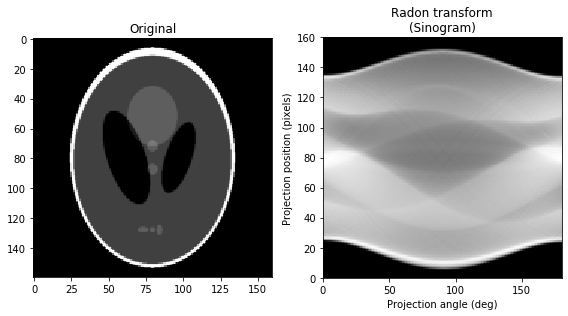

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, rescale

image = imread(data_dir + "/phantom.png", as_gray=True)
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

Reconstruction with the Filtered Back Projection (FBP)
======================================================

The mathematical foundation of the filtered back projection is the Fourier
slice theorem [2]_. It uses Fourier transform of the projection and
interpolation in Fourier space to obtain the 2D Fourier transform of the
image, which is then inverted to form the reconstructed image. The filtered
back projection is among the fastest methods of performing the inverse
Radon transform. The only tunable parameter for the FBP is the filter,
which is applied to the Fourier transformed projections. It may be used to
suppress high frequency noise in the reconstruction. ``skimage`` provides a
few different options for the filter.



FBP rms reconstruction error: 0.0283


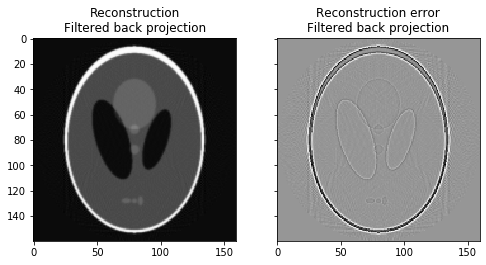

In [5]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

Reconstruction with the Simultaneous Algebraic Reconstruction Technique
=======================================================================

Algebraic reconstruction techniques for tomography are based on a
straightforward idea: for a pixelated image the value of a single ray in a
particular projection is simply a sum of all the pixels the ray passes
through on its way through the object. This is a way of expressing the
forward Radon transform. The inverse Radon transform can then be formulated
as a (large) set of linear equations. As each ray passes through a small
fraction of the pixels in the image, this set of equations is sparse,
allowing iterative solvers for sparse linear systems to tackle the system
of equations. One iterative method has been particularly popular, namely
Kaczmarz' method [3]_, which has the property that the solution will
approach a least-squares solution of the equation set.

The combination of the formulation of the reconstruction problem as a set
of linear equations and an iterative solver makes algebraic techniques
relatively flexible, hence some forms of prior knowledge can be
incorporated with relative ease.

``skimage`` provides one of the more popular variations of the algebraic
reconstruction techniques: the Simultaneous Algebraic Reconstruction
Technique (SART) [1]_ [4]_. It uses Kaczmarz' method [3]_ as the iterative
solver. A good reconstruction is normally obtained in a single iteration,
making the method computationally effective. Running one or more extra
iterations will normally improve the reconstruction of sharp, high
frequency features and reduce the mean squared error at the expense of
increased high frequency noise (the user will need to decide on what number
of iterations is best suited to the problem at hand. The implementation in
``skimage`` allows prior information of the form of a lower and upper
threshold on the reconstructed values to be supplied to the reconstruction.



SART (1 iteration) rms reconstruction error: 0.0329
SART (2 iterations) rms reconstruction error: 0.0214


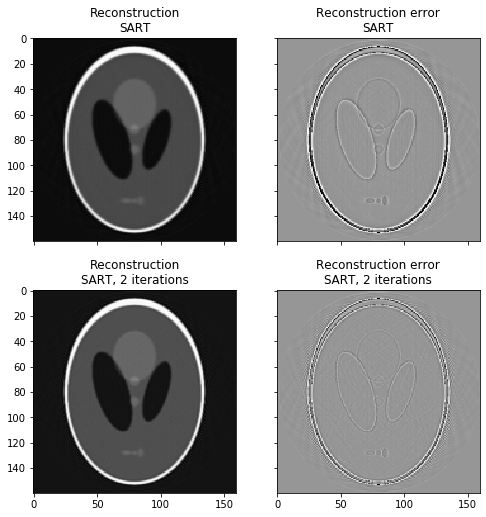

In [6]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
error = reconstruction_sart - image
print('SART (1 iteration) rms reconstruction error: %.3g'
      % np.sqrt(np.mean(error**2)))

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)
error = reconstruction_sart2 - image
print('SART (2 iterations) rms reconstruction error: %.3g'
      % np.sqrt(np.mean(error**2)))

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()